### Importing Libraries


In [32]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)


from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler

from ucimlrepo import fetch_ucirepo

from ansatz import ansatz_kazuma, ansatz_aqua

### EDA (Exploratory Data Analysis)

#### Fetching Dataset

In [33]:
# Fetching the first dataset
ionosphere = fetch_ucirepo(id=52) 

df = pd.DataFrame(ionosphere.data.features)
df["target"] = pd.DataFrame(ionosphere.data.targets)

In [34]:
features = df.drop(columns=['target'])  # Drop the target column to create the feature set
target = df['target']     

In [35]:
print("Features shape:", features.shape)  # Should match target's shape
print("Target shape:", target.shape)

# Check for missing values
print(features.isnull().sum())
print(target.isnull().sum())

# Reset index if necessary
features.reset_index(drop=True, inplace=True)
target.reset_index(drop=True, inplace=True)

Features shape: (351, 34)
Target shape: (351,)
Attribute1     0
Attribute2     0
Attribute3     0
Attribute4     0
Attribute5     0
Attribute6     0
Attribute7     0
Attribute8     0
Attribute9     0
Attribute10    0
Attribute11    0
Attribute12    0
Attribute13    0
Attribute14    0
Attribute15    0
Attribute16    0
Attribute17    0
Attribute18    0
Attribute19    0
Attribute20    0
Attribute21    0
Attribute22    0
Attribute23    0
Attribute24    0
Attribute25    0
Attribute26    0
Attribute27    0
Attribute28    0
Attribute29    0
Attribute30    0
Attribute31    0
Attribute32    0
Attribute33    0
Attribute34    0
dtype: int64
0


### Classical Approach

In [36]:
# Scaling between 0 and 1
features = PCA(n_components=5).fit_transform(features)
features = MinMaxScaler().fit_transform(features)

In [37]:
algorithm_globals.random_seed = 3459
train_features, test_features, train_labels, test_labels = train_test_split(
    features, target, train_size=0.7, random_state=algorithm_globals.random_seed
)

svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value
classical_train_score = svc.score(train_features, train_labels)
classical_test_score = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {classical_train_score:.2f}")
print(f"Classical SVC on the test dataset:     {classical_test_score:.2f}")

Classical SVC on the training dataset: 0.92
Classical SVC on the test dataset:     0.92


In [38]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [39]:
train_labels = np.array(train_labels.to_list())

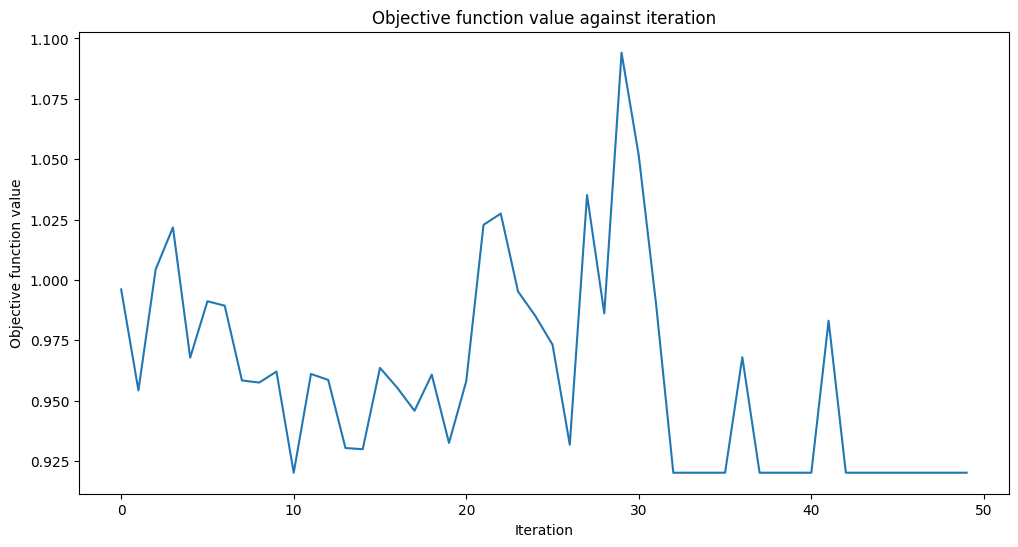

Training time: 96 seconds
Quantum VQC on the training dataset: 0.69
Quantum VQC on the test dataset:     0.70


In [40]:
# Numbers of qubits
num_features = features.shape[1]

vqc_zz_2 = VQC(
    sampler=Sampler(),
    feature_map=ZZFeatureMap(feature_dimension=num_features, reps=2),
    ansatz= ansatz_aqua(num_qubits=num_features, reps=3),
    optimizer=COBYLA(maxiter=50),
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc_zz_2.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")
quantum_train_score = vqc_zz_2.score(train_features, train_labels)
quantum_test_score = vqc_zz_2.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {quantum_train_score:.2f}")
print(f"Quantum VQC on the test dataset:     {quantum_test_score:.2f}")

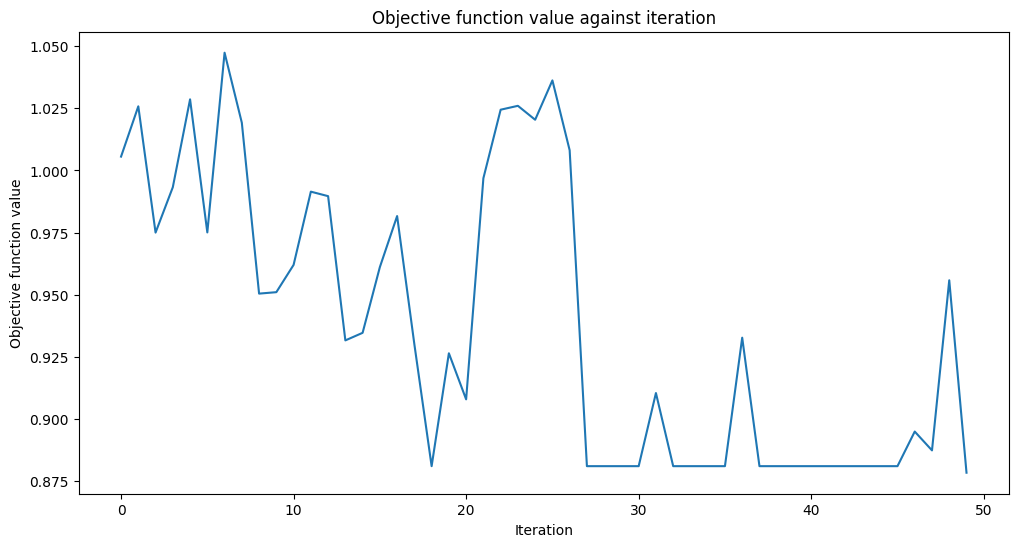

Training time: 109 seconds
Quantum VQC on the training dataset: 0.66
Quantum VQC on the test dataset:     0.75


In [41]:
# Numbers of qubits
num_features = features.shape[1]

vqc_p_2 = VQC(
    sampler=Sampler(),
    feature_map=PauliFeatureMap(
        feature_dimension=num_features, reps=2, paulis=["Z", "YY"], entanglement="full"
    ),
    ansatz=ansatz_aqua(num_qubits=num_features, reps=2),
    optimizer=COBYLA(maxiter=50),
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc_p_2.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")
quantum_train_score = vqc_p_2.score(train_features, train_labels)
quantum_test_score = vqc_p_2.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {quantum_train_score:.2f}")
print(f"Quantum VQC on the test dataset:     {quantum_test_score:.2f}")

In [42]:
dataset_name = "Ionosphere"

# Predictions
classical_predictions = svc.predict(test_features)
qc_1 = vqc_zz_2.predict(test_features)
qc_2 = vqc_p_2.predict(test_features)

# Print performance metrics with correct pos_label
print(f"""Dataset Name:\t{dataset_name}
                        Accuracy\tPrecision\tRecall\t\tF1 Score
Classical               {accuracy_score(test_labels, classical_predictions):.2f}\t\t{precision_score(test_labels, classical_predictions, pos_label='g'):.2f}\t\t{recall_score(test_labels, classical_predictions, pos_label='g'):.2f}\t\t{f1_score(test_labels, classical_predictions, pos_label='g'):.2f} 
QC (ZZ Feature Map)     {accuracy_score(test_labels, qc_1):.2f}\t\t{precision_score(test_labels, qc_1, pos_label='g'):.2f}\t\t{recall_score(test_labels, qc_1, pos_label='g'):.2f}\t\t{f1_score(test_labels, qc_1, pos_label='g'):.2f} 
QC (Pauli Feature Map)  {accuracy_score(test_labels, qc_2):.2f}\t\t{precision_score(test_labels, qc_2, pos_label='g'):.2f}\t\t{recall_score(test_labels, qc_2, pos_label='g'):.2f}\t\t{f1_score(test_labels, qc_2, pos_label='g'):.2f} 
    """)


Dataset Name:	Ionosphere
                        Accuracy	Precision	Recall		F1 Score
Classical               0.92		0.93		0.96		0.95 
QC (ZZ Feature Map)     0.70		0.83		0.69		0.76 
QC (Pauli Feature Map)  0.75		0.89		0.71		0.79 
    
